# Exploring `pytorch-lightning` With `xaitk-saliency` Integration

This example extends the "PyTorch Lightning DataModules" notebook, found [here](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/datamodules.ipynb), for multi-GPU based training. Additionally, this notebook will explore integrating `xaitk-saliency` and `pytorch-lightning` to generate saliency maps for model predictions.

## Table of Contents

* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [Introduction](#introduction)
  * [Defining the `MNISTDataModule`](#defining-mnist-data-module)
  * [Defining the Dataset Agnostic `LitModel`](#defining-dataset-agnostic-lit-model)
    * [Accelerator Code Preparation](#accelerator-code-preparation)
  * [Training `LitModel` Using the `MNISTDataModule`](#training-lit-model-for-mnist)
    * [PyTorch Lightning's Trainer](#pytorch-lightnings-trainer)
    * [Accelerators and Distributed Modes](#accelerators-and-distributed-modes)
      * [Selecting Accelerator Devices](#selecting-accelerator-devices)
      * [Distributed Modes](#distributed-modes)
  * [Defining the `CIFAR10DataModule`](#defining-cifar10-data-module)
  * [Training `LitModel` Using the `CIFAR10DataModule`](#training-lit-model-for-cifar10)
* [`xaitk-saliency` Integration](#xaitk-integration)
    * [Defining `LitSaliencyModel`](#defining-lit-saliency-model)
    * [Perturber and Saliency Generator](#perturber-and-saliency-generator)
    * [Saliency Generator](#saliency-generator)
    * [Generate Saliency Maps](#generate-saliency-maps)
  

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing torchmetrics...")
!{sys.executable} -m pip install -q 'torchmetrics>=0.7'
print("Installing ipython...")
!{sys.executable} -m pip install -q ipython[notebook]
print("Installing setuptools...")
!{sys.executable} -m pip install -q 'setuptools==59.5.0'
print("Installing torch...")
!{sys.executable} -m pip install -q 'torch>=1.8'
print("Installing pytorch-lightning...")
!{sys.executable} -m pip install -q 'pytorch-lightning>=1.4'
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Done!")

Installing torchmetrics...
Installing ipython...
Installing setuptools...
Installing torch...
Installing pytorch-lightning...
Installing torchvision...
Installing xaitk-saliency...
Done!


## Imports <a name="imports"></a>

In [2]:
import os

import torch
import torch.nn.functional as F
from pytorch_lightning import Callback, LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch import nn
from torch.utils.data import Dataset, IterableDataset, DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision import transforms

# Note you must have torchvision installed for this example
from torchvision.datasets import CIFAR10, MNIST

# xaitk-saliency integration imports
from smqtk_classifier import ClassifyImage
from typing import Iterable, Dict, Hashable, Tuple, Sequence, Any
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency
from xaitk_saliency.interfaces.perturb_image import PerturbImage
import numpy as np
import matplotlib.pyplot as plt
from xaitk_saliency.utils.masking import occlude_image_streaming, occlude_image_batch
from xaitk_saliency.impls.gen_classifier_conf_sal.occlusion_scoring import OcclusionScoring
from xaitk_saliency import GenerateClassifierConfidenceSaliency

from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow
from pytorch_lightning.loops.epoch import PredictionEpochLoop
from lightning_lite.utilities import move_data_to_device

In [3]:
from pytorch_lightning import seed_everything

# For reproducability
seed_everything(0, workers = True)

Global seed set to 0


0

## Introduction <a name="introduction"></a>

A `LightningModule` _is_ a PyTorch `nn.Module`, with additional features. A `LightningDataModule` is a way of decoupling data-related hooks from the `LightningModule` to develop dataset agnostic models. In this notebook, we'll define two `DataModule`s to showcase this dataset agnostic capability.

### Defining the `MNISTDataModule` <a name="defining-mnist-data-module"></a>

First, we'll define an MNIST `LightningDataModule`. There are various components to a `LightningDataModule`:

* `__init__`
  * Takes in a `data_dir` arg that points to where you have downloaded/wish to download the MNIST dataset.
  * Defines a transform that will be applied across train, val, and test dataset splits.
  * Defines default `self.dims`.
* [`prepare_data()`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#prepare-data)
  * This is where we can download the dataset. We point to our desired dataset and ask torchvision's MNIST dataset class to download if the dataset isn't found there.
  * __Note we do not make any state assignments in this function__ (i.e. `self.something = ...`)
* [`setup(stage)`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#setup)
  * Loads in data from file and prepares PyTorch tensor datasets for each split (train, val, test).
  * Setup expects a 'stage' arg which is used to separate logic for 'fit' and 'test'.
  * If you don't mind loading all your datasets at once, you can set up a condition to allow for both 'fit' related setup and 'test' related setup to run whenever `None` is passed to `stage`.
  * __Note this runs across all GPUs and it _is_ safe to make state assignments here__
* [`x_dataloader()`](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.core.hooks.DataHooks.html#pytorch_lightning.core.hooks.DataHooks.train_dataloader)
  * `train_dataloader()`, `val_dataloader()`, and `test_dataloader()` all return PyTorch `DataLoader` instances that are created by wrapping their respective datasets that we prepared in `setup()`

Note: If the `ddp_notebook` or `ddp_fork` distributed mode is used, GPU operations such as moving tensors to the GPU or calling `torch.cuda` functions before invoking `Trainer.fit` are not allowed so we will avoid doing so now (more on distributed modes later).

In [4]:
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
#BATCH_SIZE = 256 if torch.cuda.is_available() else 64
BATCH_SIZE = 256

In [5]:
class MNISTDataModule(LightningDataModule):
    def __init__(self, data_dir: str = PATH_DATASETS):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)
    
    def get_transform(self):
        return self.transform

### Defining the Dataset Agnostic `LitModel` <a name="defining-dataset-agnostic-lit-model"></a>

Below we define the same `LitMNIST` model as was defined in [PyTorch Lightning's MNIST Hello World Notebook](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/mnist-hello-world.ipynb). However, this time our model has the freedom to use any input data we'd like. We'll also make some slight modifications to the model, noted in the following section, to ensure our model can scale without changes.

#### [Accelerator Code Preparation <a name="accelerator-code-preparation"></a>](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/accelerator_prepare.html)

There are some code preparation details to keep in mind to train on any accelerator without changing code, summarized here:

* Remove any `.cuda()` or `.to()` calls
* Init tensors using `type_as` and `register_buffer`
* Remove samplers
* Syncronize validation and test logging (add `sync_dist=True` to all `self.log` calls in the validation and test step)
* Make models pickleable

We'll make those sure we're following those guidelines here.

In [6]:
class LitModel(LightningModule):
    def __init__(self, channels, width, height, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.channels = channels
        self.width = width
        self.height = height
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, prog_bar=True, sync_dist=True)
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        # this calls forward
        return self(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

### Training `LitModel` Using the `MNISTDataModule` <a name="training-lit-model-for-mnist"></a>

Now, we initialize and train the `LitModel` using the `MNISTDataModule`'s configuration settings and dataloaders.

#### PyTorch Lightning's Trainer <a name="pytorch-lightnings-trainer"></a>

The [trainer](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html) automates much of what is done manually in vanilla PyTorch once our model is organized within a `LightningModule`. If there's any key part you don't want automated, the trainer allows overrides.

Under the hood, the trainer handles training details including:
- Automatically enabling/disabling grads
- Running the training, validation, and test dataloaders
- Calling the callbacks at the appropriate times
- Putting batches and computations on the correct devices

[`.fit(..)`](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer.fit) runs the whole optimization routine.

Basic trainer usage:
```
model = MyLightningModule()

trainer = Trainer()
trainer.fit(model, my_data_module)
```

#### Accelerators and Distibuted Modes <a name="accelerators-and-distributed-modes"></a>

Since we followed the acclerator code preparation notes above, we can easily train our model on any number/type of accelerator device(s).

##### [Selecting Accelerator Devices <a name="selecting-accelerator-devices"></a>](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_basic.html)

You can select devices using ranges, a list of indices or a string containing a comma separated list of device ids:

```
# Default (int) specifies how many devices to use per node
Trainer(accelerator="gpu", devices=k)

# Above is equivalant to
Trainer(accelerator="gpu", devices=list(range(k)))

# Specify which devices to use (don't use when running on cluster)
Trainer(accelerator="gpu", devices=[0, 1])

# String equivalent
Trainer(accelerator="gpu", devices='0, 1')

# To use all available devices put -1 or '-1'
# equivalent to list(range(torch.cuda.device_count()))
Trainer(accelerator="gpu", devices=-1)
```

Supported accelerators include: cpu, gpu, tpu, ipu, hpu, mps, auto and custom accelerator instances.

##### [Distributed Modes <a name="distributed-modes"></a>](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_intermediate.html)

PyTorch Lightning supports multiple ways of doing distributed training.

* Data Parallel (`strategy='dp'`) (multiple-gpus, 1 machine)
* Distributed Data Parallel (multiple-gpus across many machines)
  * Regular (`strategy='ddp'`)
  * Spawn (`strategy='ddp_spawn'`) (automatically used when no mode is set but multiple devices requested)
  * Notebook/Fork (`strategy='ddp_notebook'`) (note Windows is not supported)
* Horovod (`strategy='horovod'`) (multi-machine, multi-gpu, configured at runtime)
* Bagua (`strategy='bagua'`) (multiple-gpus across many machines with advanced training algorithms)

__Note only `dp` and `ddp_notebook` strategies can be used in interactive environments such as notebooks__

`ddp` is the usual recommended go-to strategy for its speed and stability but it can only be used with scripts.

In [7]:
# Init DataModule
mnist_dm = MNISTDataModule()
# Init model from datamodule's attributes
mnist_model = LitModel(*mnist_dm.dims, mnist_dm.num_classes)
# Init trainer
mnist_trainer = Trainer(
    max_epochs=3,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    accelerator="auto",
    devices=-1,
    strategy="dp",
)
# Pass the datamodule as arg to trainer.fit to override model hooks :)
mnist_trainer.fit(mnist_model, mnist_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.1 K
-------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


### Defining the `CIFAR10DataModule` <a name="defining-cifar10-data-module"></a>

Prove `LitModel` is dataset agnostic by defining a new `DataModule` for the CIFAR10 dataset.

In [8]:
class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.dims = (3, 32, 32)
        self.num_classes = 10

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=False, download=True)
        CIFAR10(self.data_dir, train=True, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000], generator=torch.Generator().manual_seed(0))

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage == "predict" or stage is None:
            cifar_full_test = CIFAR10(self.data_dir, train=False, transform=self.transform)
            predict_size = 5
            test_size = len(cifar_full_test) - predict_size
            self.cifar_test, self.cifar_predict = random_split(cifar_full_test, [test_size, predict_size], generator=torch.Generator().manual_seed(0))

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE)
    
    def predict_dataloader(self):
        return DataLoader(self.cifar_predict, batch_size=BATCH_SIZE)
    
    def get_transform(self):
        return self.transform

### Training `LitModel` using the `CIFAR10DataModule` <a name="training-lit-model-for-cifar10"></a>

This model isn't very good, so it will perform badly on the CIFAR10 dataset.

The point here is that we can see our `LitModel` has no problem using a different datamodule as its input data.

In [9]:
cifar10_dm = CIFAR10DataModule()
cifar10_model = LitModel(*cifar10_dm.dims, cifar10_dm.num_classes, hidden_size=256)
tqdm_progress_bar = TQDMProgressBar(refresh_rate=20)
cifar10_trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=-1,
    strategy="dp",
    callbacks=[tqdm_progress_bar],
)
cifar10_trainer.fit(cifar10_model, cifar10_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 855 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


## `xaitk-saliency` Integration <a name="xaitk-integration"></a>

### Defining `LitSaliencyModel` <a name="defining-lit-saliency-model"></a>

Here we will define `LitSaliencyModel` which overrides the `predict_step` function of `LitModel` to add saliency map generation for each image that we predict on. The "driver" of this added functionality is `gen_saliency_maps(ref_preds, imgs)`.

To generate saliency maps, we'll need a pertubation implementation and a saliency generator.

Within `gen_saliency_maps(..)`, there are 3 main steps:
1. Generate perturbed data via the perturber
2. Predict upon the perturbed data
3. Using these prediction results, the saliency generator will generate heat maps


In [10]:
class LitSaliencyModel(LitModel):
    def __init__(
        self, 
        channels, 
        width, 
        height, 
        num_classes,
        perturber: PerturbImage,
        saliency_generator: GenerateClassifierConfidenceSaliency,
        labels: Sequence[Hashable]=None,
        hidden_size=64, 
        learning_rate=2e-4,
        process = 'batch',
        threads: int=4,
    ):
        super().__init__(
            channels, 
            width, 
            height, 
            num_classes,
            hidden_size=64, 
            learning_rate=2e-4,
        )

        self.perturber = perturber
        self.generator = saliency_generator
        self.labels = labels
        if self.labels is None:
            self.labels = list(range(self.num_classes))
            
        self.process = process
        self.threads = threads
        # Optional fill color
        self.fill: Optional[Union[int, Sequence[int]]] = None
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
            
        # this calls forward
        preds = self(x)
        
        self._gen_saliency_maps(preds, x)
        
        return preds
    
    def _gen_saliency_maps(
        self,
        ref_preds: Any,
        imgs: Any
    ) -> None:
        sal_maps_set = []
        ref_imgs = []
        for ref_pred, ref_img in zip(ref_preds, imgs):
            # Lightning data is channel first
            ref_img = ref_img.cpu().permute(1,2,0).data.numpy()
            ref_imgs.append(ref_img)

            # Generate pertubation masks
            pert_masks = self.perturber(ref_img)

            # Confidence value setup
            ref_conf_dict = list(self._classify_preds([ref_preds]))[0]
            ref_conf_vec = np.asarray([ref_conf_dict[la] for la in self.labels])
            pert_conf_mat = np.empty(
                (pert_masks.shape[0], ref_conf_vec.shape[0]),
                dtype=ref_conf_vec.dtype
            )

            # Genertate perturbed images
            pert_imgs_it = self._gen_perturbed_imgs(ref_img, pert_masks)
            pert_imgs_it = np.transpose(pert_imgs_it, (0, 3, 1, 2))

            # Predict on perturbed images
            pert_outputs = []
            dataloader = DataLoader(
                 self._MaskDataset(pert_imgs_it, imgs),
                 shuffle=False
             )
            for data in dataloader:
                pert_outputs.append(self(data))
            pert_conf_it = self._classify_preds(pert_outputs)

            # Format confidence values for generator
            for i, pc in enumerate(pert_conf_it):
                pert_conf_mat[i] = [pc[la] for la in self.labels]

            # Generate saliency map
            sal_maps_set.append(
                self.generator(
                    ref_conf_vec,
                    pert_conf_mat,
                    pert_masks,
            ))
            
        # Plot each image in set with saliency maps
        self._plot_saliency_maps(sal_maps_set, ref_imgs)
    
    class _MaskDataset(Dataset):
        def __init__(self, imgs, ref_tensor = None):
            self.imgs = imgs
            self.to_tensor = transforms.ToTensor()
            self.ref_tensor = ref_tensor
            
        def __len__(self):
            return len(self.imgs)
        
        def __getitem__(self, index):
            img = self.to_tensor(self.imgs[index])
            if self.ref_tensor is not None:
                img = img.type_as(self.ref_tensor)
            return img
        
    def _gen_perturbed_imgs(self, ref_img, pert_masks):
        if self.process == 'stream':
            pert_imgs_it = occlude_image_streaming(
                ref_img, 
                pert_masks,
                fill = self.fill,
                threads = self.threads
            )
        elif self.process == "batch":
            pert_imgs_it = occlude_image_batch(
                ref_img, 
                pert_masks,
                fill = self.fill,
                threads = self.threads
            )
        
        return pert_imgs_it
    
    def _classify_preds(self, preds):
        results = []
        for pred in preds:
            max_idx = torch.argmax(pred)
            r = {}
            for idx in range(len(self.labels)):
                if idx == max_idx:
                    r[self.labels[idx]] = 1.
                else:
                    r[self.labels[idx]] = 0.
            results.append(r)
            
        return results
    
    def _plot_saliency_maps(self, sal_maps_set, ref_imgs):
        for i in range(len(sal_maps_set)):
            plt.figure(figsize=(10,5))
            num_cols = np.ceil(self.num_classes/2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow(ref_imgs[i], cmap='gray')
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")
            for c in range(self.num_classes - num_cols + 1, self.num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")


### Perturber and Saliency Generator <a name="perturber-and-saliency-generator"></a>

We create an instance of `SlidingWindow`, an implementation of the `PerturbImage` interface, to carry out our image pertubation and an instance of `OcclusionScoring`, an implementation of the `GenerateClassifierConfidenceSaliency` interface, for heatmap generation.

In [11]:
sliding_window_perturber = SlidingWindow(
    window_size=(2, 2),
    stride=(1, 1),
)
sal_map_generator = OcclusionScoring()

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

With our new `LitSaliencyModel`, we just have to call predict on our trained model to generate saliency maps across all predicted images.

In [12]:
labels = ['Plane', 'Car', 'Bird', 'Cat',
           'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

cifar10_dm = CIFAR10DataModule()
cifar10_model = LitSaliencyModel(
    *cifar10_dm.dims, 
    cifar10_dm.num_classes,
    sliding_window_perturber,
    sal_map_generator,
    labels=labels,
    hidden_size=256
)
tqdm_progress_bar = TQDMProgressBar(refresh_rate=20)
cifar10_trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices=-1,
    strategy="dp",
    callbacks=[tqdm_progress_bar],
)
cifar10_trainer.fit(model=cifar10_model, datamodule=cifar10_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 201 K 
-------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.806     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


We know our model doesn't perform well on this dataset and these results confirm that the model has difficulty discriminate between CIFAR10 classes. It's not clear which features the model is trying to focus on, if it is able to identify any at all, for many of the samples.

Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /home/khq.kitware.com/emily.veenhuis/xaitk-cdao/examples/lightning/lightning_logs/version_76/checkpoints/epoch=4-step=880.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /home/khq.kitware.com/emily.veenhuis/xaitk-cdao/examples/lightning/lightning_logs/version_76/checkpoints/epoch=4-step=880.ckpt
/home/khq.kitware.com/emily.veenhuis/miniconda3/envs/pytorch-lightning-test/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 176it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


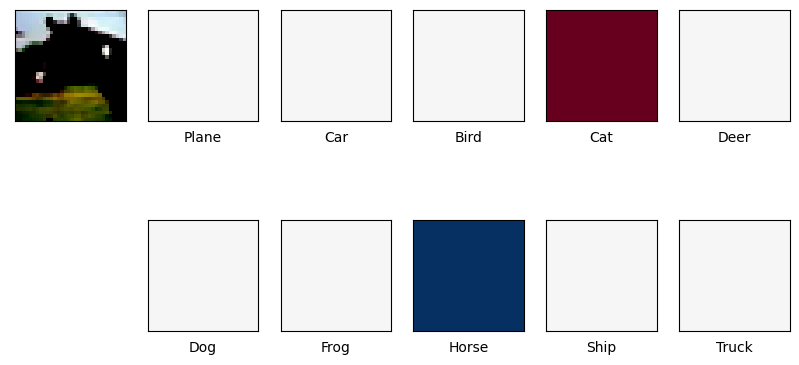

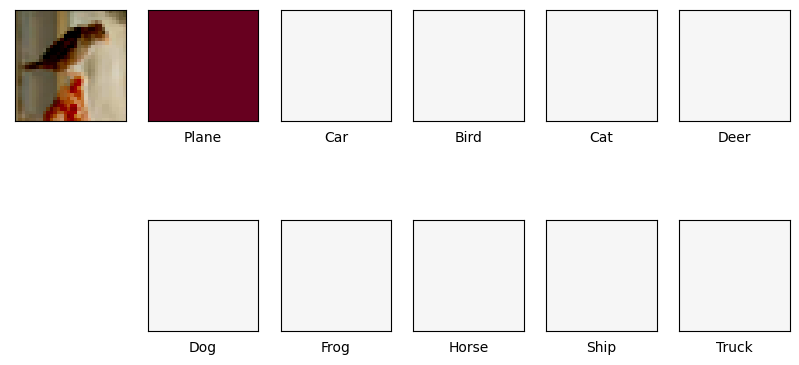

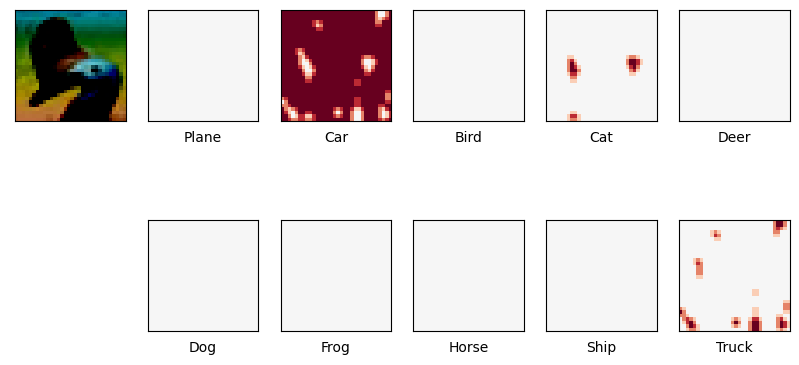

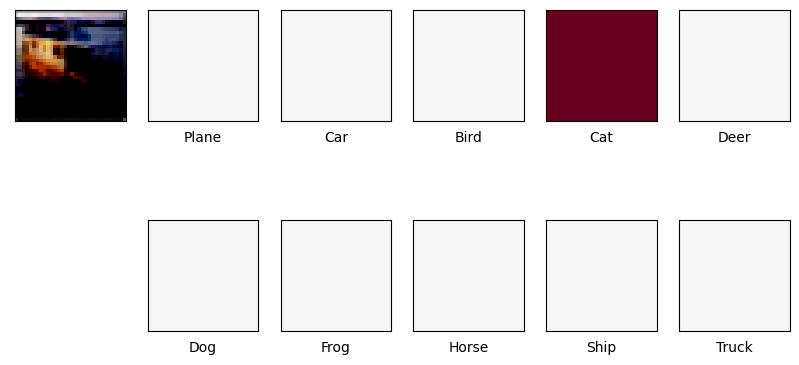

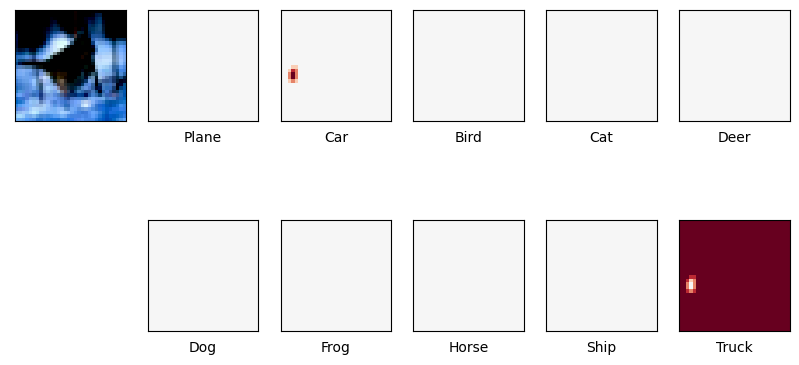

In [13]:
preds = cifar10_trainer.predict(ckpt_path='best', datamodule=cifar10_dm)